# Time-scale correction for $\delta^{18} O$ data using Bayesian inference

- Eugenio Fella
- Matteo Pedrazzi
- Gaetano Ricucci
- Carlo Sgorlon Gaiatto

# Introduction
The $\delta^{18}O$ is a measure of the ratio between the stables isotopes of the oxygen $^{18}O$ and $^{16}O$, and it is commonly used in paleoclimatology. This indicator is usually evaluated retrieving data from ice cores and it can be used as a proxy for the temperature from when the ice was formed. Changes in the Earth's position relative to the Sun affect the amount and distribution of sunlight the Earth receives, also reffered to as insolation, and they are expected to introduce periodic climatic variations on time scales of 20-100 kyr. Long sedimentation records, such as ice cores in this case, are capable of recording such variations; however, they often have poorly constrained age scales. The purpose of our project is to correct with Bayesian inference the time scale of the $\delta^{18}O$ record by exploiting the cycles obtained by analyzing three insolation records. This procedure is commonly known as orbital tuning.

# Synthetic study
The real dataset is composed by a $\delta^{18}O$ record, characterized by a corrupted time scale that goes from $1250 \hspace{1mm} \text{YBP}$ to $144050 \hspace{1mm} \text{YBP}$ in steps of $100$, and three insolation records $\big[W/m^2\big]$ (global, 65°N and 75°S), derived from the Earth's relative position to the Sun with high accuracy and containing the exact cycles. The $\delta^{18}O$ record has been analyzed by means of the Bretthorst method, a Bayesian method that is able to infer periods, amplitudes and phases but without considering the time-scale correction. The periods derived by this method have been associated with the closest periods extracted from the insolation records. Before analyzing the real $\delta^{18}O$ record we have simulated it using the associated insolation cycles and the ampltidues and phases from the Bretthorst analysis. We modelled the time-scale corruption using an autoregressive model of order 1, that can be seen as the discretization of the Ornstein-Uhlenbeck process.

# Ornstein–Uhlenbeck process

It is a diffusion process whose path can be described by a stochastic differential equation:

$$
dx(t) = f(x(t)) \cdot dt + \sqrt{2D} \cdot dB(t)
$$

where $f(x(t))$ is a function of $x(t)$, $D$ is the diffusion coefficient and $B(t)$ is a Wiener process.

From  a physical point of view, it is a stochastic process that correspond to a particle moving in a harmonical potential $U_{ext}(x)$ and subject to thermal noise caused by the medium. The process can be considered to be a modification of the Brownian motion in which the properties of the process have been changed so that there is a tendency of the path to move back towards a central location, with a greater attraction when the process is further away from the center. It can be show that $f(x(t))$ corresponds to the external force $F_{ext}$ divided by the friction coefficient $\gamma$ (dimension: $[\gamma] = M/T$). Therefore it is possible to get the form of $f(x(t))$:

$$
U_{ext}(x) = \frac{1}{2}m w^2 x^2
$$

$$
F_{ext} = - d_x U_{ext}(x) = - m w^2 x := - k x
$$

where $k$ (dimension: $[k] = M/T^2$) can be thought as the spring constant. Then:

$$
f(x(t)) = - \frac{k}{\gamma} \cdot x(t)
$$

where $\big[\frac{k}{\gamma}\big] = T^{-1}$. The stochastic differential equation becomes:

$$
dx(t) = - \frac{k}{\gamma} \cdot x(t) \cdot dt + \sqrt{2D} \cdot dB(t)
$$

In general, the spring rest length $\mu$ can be different from $0$, thus:

$$
dx(t) = \frac{k}{\gamma} \cdot (\mu - x(t)) \cdot dt + \sqrt{2D} \cdot dB(t)
$$

The quantity $k/\gamma$ is usually replaced by the parameter $\tau$ representing the time scale of the process (dimension: $[\tau] = T$), while the factor that multiplies the Wiener process is restated using $\tau$ to make the asymptotic standard deviation $\sigma$ of the process appear:

$$
dx(t) = \frac{1}{\tau} \cdot (\mu - x(t)) \cdot dt + \sigma \cdot \sqrt{\frac{2}{\tau}} \cdot dB(t)
$$



# Autoregressive model

It is possible to discretize an Ornstein-Uhlenbeck process using the Euler-Maruyama approximation, obtaining the so-called autoregressive model of order 1:

$$
x(t_{i}) = x(t_{i-1}) + \frac{1}{\tau} \cdot (\mu - x(t_{i-1})) \cdot \Delta t + \sigma \cdot \sqrt{\frac{2}{\tau}} \cdot \sqrt{\Delta t} \cdot Z(t_i)
$$

where $\Delta t := t_{i} - t_{i-1}$ and  $Z(t_i) \sim \mathcal{N}(0, 1)$.

Rearranging the terms gives the following:

$$
x(t_{i}) = \mu \cdot \frac{\Delta t}{\tau} + \bigg(1 - \frac{\Delta t}{\tau}\bigg) \cdot x(t_{i-1}) + \sigma \cdot \sqrt{\frac{2 \cdot \Delta t}{\tau}} \cdot Z(t_i)
$$

Since $\Delta t$ and $\tau$ appear always as a ratio, a different set of parameters $a$, $b$ and $c$ can be used:

$$
x_{i} = a + b \cdot x_{i-1} + c \cdot \epsilon_i
$$

where $-1 < b < 1$ (for stationarity) and $\epsilon_i \sim \mathcal{N}(0, 1)$.

The expected value and variance of such a process are:

$$
\text{E}[x] = a/(1 - b)
$$

$$
\text{Var}(x) = c^2/(1 - b^2)
$$


In [80]:
# import libraries
import numpy as np
seed = 12345

import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8

import pandas as pd

from statsmodels.graphics.tsaplots import plot_acf

import nest_asyncio
nest_asyncio.apply()
import stan

In [2]:
# set colors 
col_red = '#E21B1B'   #red
col_blue = '#1769E6'  #blue
col_green = '#00D10A' #green
col_grey = '#C8CED0'  #gray

We import into the dataframe <code>df_cycle</code> the amplitudes and the phases (and the relative standard deviations) of the $N_{cycle}=29$ cycles found in the $\delta^{18}O$ record by means of the Bretthorst method. The closest exact periods in the insolation records are taken as the periods (and thus frequencies $f_l$) of these cycles. They are decreasing sorted by amplitude.

In [3]:
# observed data
N_cycle = 29
df_cycle = pd.read_table('data/d18O_cycles.txt', delimiter = ',')

df_cycle

,period,A,sigma_A,ph,sigma_ph
0,4321.4,0.1782,0.0086,1.97,0.04
1,5972.6,0.1719,0.0098,0.69,0.11
2,6308.0,0.1509,0.0119,3.05,0.12
3,4792.5,0.1478,0.0077,4.77,0.10
4,5587.2,0.1288,0.0145,0.24,0.17
5,3039.6,0.1251,0.0070,1.94,0.10
6,7180.2,0.1182,0.0095,3.56,0.15
7,3892.1,0.1119,0.0111,6.26,0.19
8,4180.6,0.1117,0.0074,3.62,0.18
9,3245.1,0.1085,0.0147,0.13,0.13


In [4]:
# cycles
period = df_cycle['period'].values

# frequencies
freq = 1/period

# Corrupted time-scale

We compute a realization of the auto-regressive model  as:

$$
\xi_{i} = \mu \cdot \frac{\Delta t}{\tau} + \bigg(1 - \frac{\Delta t}{\tau}\bigg) \cdot \xi_{i-1} + \sigma \cdot \sqrt{2 \cdot \frac{\Delta t}{\tau}} \cdot \epsilon_{i}
$$

or equivalently

$$
\xi_{i} = a + b \cdot \xi_{i-1} + c \cdot \epsilon_{i}
$$

where $\epsilon_{i} \sim \mathcal{N}(0, 1)$ and $i$ goes from 0 to $n$, namely the number of time steps of the dataset.

We have considered:

$ \mu = 100 $ yr 

$ \sigma = 5 $ yr

$ \Delta t =100 $ yr

$\tau = 1500 $ yr.

To check the consistency of the results we compare the mean and the standard deviation of the $\xi$ with $\mu$ and $\sigma$.

In [5]:
np.random.seed(seed)

# auto-regressive model
mean = 100
sd = 5
dt = 100
tau = 1500

n = 1429
xi = np.zeros(n)
xi[0] = mean
for i in range(1, len(xi)):
    # normal-distributed independent random increments
    eps = np.random.normal(0, 1)
    xi[i] = mean*dt/tau + (1 - dt/tau)*xi[i-1] + sd*np.sqrt(2*dt/tau)*eps

print('mean')
print('expected:',  np.around(mean, 3), 'yr', 'sample:', np.around(xi.mean(), 3), 'yr')
print('sd')
print('expected:', np.around(sd, 3), 'yr', 'sample:', np.around(np.sqrt(xi.var()), 3), 'yr')

mean
expected: 100 yr sample: 99.642 yr
sd
expected: 5 yr sample: 4.907 yr


We plot the obtained $\xi_i$ as a function of the regular time scale of the dataset $t_{reg, i}$ (expressed in YBP):
$$
t_{reg, i} = 1250 + i\cdot100
$$

In [58]:
# plot auto-regressive model
def plot_AR(y, t, start, end):

    y = y[start:end]
    t = t[start:end]

    # plot
    fig, ax = plt.subplots(figsize=(24,8))

    ax.plot(t, y, color=col_blue)
    ax.axhline(y=100, color=col_red, linestyle='--')
    ax.set_xlabel('t_reg [YBP]', fontsize = 23)
    ax.set_ylabel(r'$\xi$ [yr]', fontsize = 23)
    ax.set_title('Simulated auto-regressive process', fontsize=27)
    ax.tick_params(axis='x',labelsize=14)
    ax.tick_params(axis='y',labelsize=14)
    ax.grid()
    plt.show()

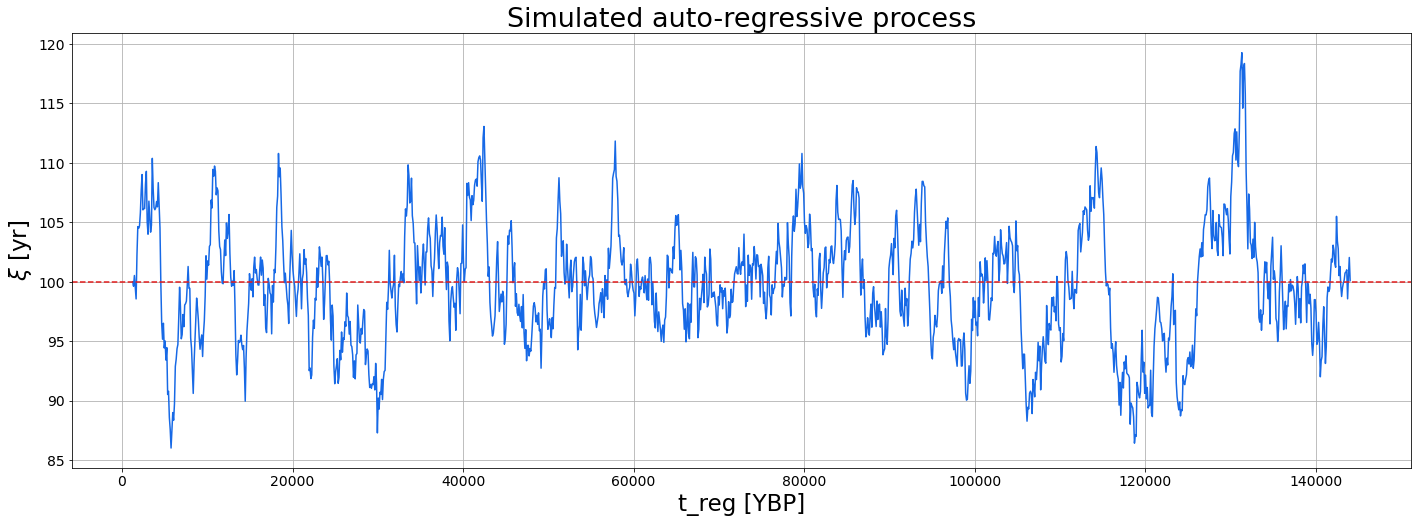

In [59]:
# regular time
t_reg = 1250 + np.arange(0, 100*n, 100)

# plot auto-regressive model
plot_AR(xi, t_reg, 0, n)

The corrupted time-scale is generated as:

$$
t_{corr,i} = t_{corr,i-1} + \xi_{i}
$$
starting from $t_{corr,0}$ = 1250 YBP. 

Note that since the variance of $\xi$ is very small with respect to $\mu=100$ yr (that is set equal to the regular time scale step), the probability of generating non-monotonically increasing time steps is negligible.<br>

In [8]:
# corrupted time
t_corr = np.zeros(n)
t_corr[0] = 1250

for i in range(1, len(t_corr)):
    t_corr[i] = t_corr[i-1] + xi[i]

Finally we generate the simulated signal as:

$$
y_{corr, i} = \sum_{l=1}^{N_{cycle}}(A_l\cos(\omega_l t_{corr,i}+\phi_l))
$$

where $\omega_l =  2\pi \cdot f_l$ (expressed in $[1/yr]$).

$A_l$ and $\phi_l$ (displayed in the following block) are extracted from gaussians with mean and standard deviation the respective values in <code>df_cycle</code>.
Then a white noise $\epsilon_{i} \sim \mathcal{N}(0, 1)$ is added to the signal to simulate an observed dataset:

$$
y_{corr\_obs, i} = y_{corr, i} + \sigma_y\cdot\epsilon_{i}
$$

with $\sigma_y=0.2$ ‰.

In [9]:
np.random.seed(seed)

# amplitudes
A = np.random.normal(df_cycle['A'].values, df_cycle['sigma_A'].values)

# phases
ph = np.random.normal(df_cycle['ph'].values, df_cycle['sigma_ph'].values)
ph = abs(ph)

# model corrupted
y_corr = np.zeros(len(t_corr))
for i in range(0, N_cycle):
    y_corr += A[i]*np.cos(2*np.pi*freq[i]*t_corr + ph[i])

# model regular
y_reg = np.zeros(len(t_reg))
for i in range(0, N_cycle):
    y_reg += A[i]*np.cos(2*np.pi*freq[i]*t_reg + ph[i])

# noise
sigma_y = 0.2
noise = sigma_y*np.random.normal(0, 1, len(t_corr))

# observed data
y_corr_obs = y_corr + noise

In [10]:
# auto-regressive parameters 
param_AR = {'mean':mean, 'sd':sd, 'tau':tau}
#param_AR = {'mean':mean, 'sd':sd}

# sigma_y parameter
param_sigma_y = {'sigma_y':sigma_y}

# A parameters
param_A = {}
for i in range(0, N_cycle):
    key = 'A.'+str(i+1)
    param_A[key] = A[i]

# ph parameters
param_ph = {}
for i in range(0, N_cycle):
    key = 'ph.'+str(i+1)
    param_ph[key] = ph[i]

# t parameters
param_t = {}
for i in range(0, len(t_corr)):
    key = 't.'+str(i)
    param_t[key] = t_corr[i]

# concatenate dictionaries
param = {**param_AR, **param_sigma_y, **param_A, **param_ph}
    
for key in list(param.keys()):
    print(key+':', round(param[key], 4))

mean: 100
sd: 5
tau: 1500
sigma_y: 0.2
A.1: 0.1764
A.2: 0.1766
A.3: 0.1447
A.4: 0.1435
A.5: 0.1573
A.6: 0.1349
A.7: 0.1191
A.8: 0.115
A.9: 0.1174
A.10: 0.1268
A.11: 0.1217
A.12: 0.0928
A.13: 0.1016
A.14: 0.1005
A.15: 0.1059
A.16: 0.0987
A.17: 0.0647
A.18: 0.0842
A.19: 0.0955
A.20: 0.0722
A.21: 0.0712
A.22: 0.0787
A.23: 0.1191
A.24: 0.0628
A.25: 0.0683
A.26: 0.0716
A.27: 0.0665
A.28: 0.0657
A.29: 0.058
ph.1: 2.0238
ph.2: 0.6115
ph.3: 2.9503
ph.4: 4.533
ph.5: 0.0763
ph.6: 1.8539
ph.7: 3.644
ph.8: 6.0195
ph.9: 3.6416
ph.10: 0.0083
ph.11: 0.8132
ph.12: 5.1561
ph.13: 2.7901
ph.14: 4.1787
ph.15: 2.3676
ph.16: 3.3232
ph.17: 6.0431
ph.18: 1.0483
ph.19: 4.4692
ph.20: 1.5331
ph.21: 0.8549
ph.22: 0.2403
ph.23: 0.4744
ph.24: 1.3674
ph.25: 6.3409
ph.26: 6.3349
ph.27: 5.181
ph.28: 1.3898
ph.29: 4.1104


Everything is collected in the dataframe <code>df_sim</code>.

In [11]:
df_sim = pd.DataFrame(data = {'xi':xi,
                            't_corr':t_corr, 'y_corr':y_corr,
                            't_reg':t_reg, 'y_reg':y_reg,
                            'y_corr_obs':y_corr_obs})
df_sim

,xi,t_corr,y_corr,t_reg,y_reg,y_corr_obs
0,100.000000,1250.000000,0.239315,1250,0.239315,0.390987
1,99.626257,1349.626257,0.328466,1350,0.328735,0.196361
2,100.525600,1450.151856,0.380001,1450,0.379956,0.552517
3,99.542199,1549.694055,0.386360,1550,0.386308,0.384353
4,98.558099,1648.252154,0.347906,1650,0.346842,0.357908
...,...,...,...,...,...,...
1424,101.003174,143136.803435,-0.002543,143650,-0.256861,0.324428
1425,98.567470,143235.370905,-0.029971,143750,-0.314988,-0.359109
1426,100.484600,143335.855505,-0.071076,143850,-0.360769,-0.152509
1427,102.042432,143437.897938,-0.124944,143950,-0.387720,-0.175497


Here the signals $y_{corr\_obs, i}$ and $y_{reg, i}$ (respectively the simulated data and the generative model) are plotted as a function of $t_{reg, i}$, where:

$$
y_{reg, i} = \sum_{l=1}^{N_{cycle}}(A_l\cos(\omega_l t_{reg,i}+\phi_l)).
$$



In [148]:
# plot simulation
def plot_simulation(df, start, end):

    df = df[start:end]

    # plot
    fig, ax = plt.subplots(figsize=(28,8))

    ax.plot(df['t_reg'], df['y_corr_obs'], color=col_blue, label='simulated data')
    #ax.plot(df['t_reg'], df['y_corr'], color='b', label='observed data')
    ax.plot(df['t_reg'], df['y_reg'], color=col_red, label='generative model',lw=2)
    ax.set_xlabel('t_reg [YBP]', fontsize=25)
    ax.set_ylabel('y [‰]', fontsize=25)
    ax.set_ylim((max(df['y_reg']) + 3*sigma_y)*np.array([-1, 1]))
    ax.set_title('Simulated dataset with time-scale corruption', fontsize=30)
    ax.tick_params(axis='x',labelsize=18)
    ax.tick_params(axis='y',labelsize=18)
    ax.legend(fontsize=18)
    plt.grid()
    plt.show()

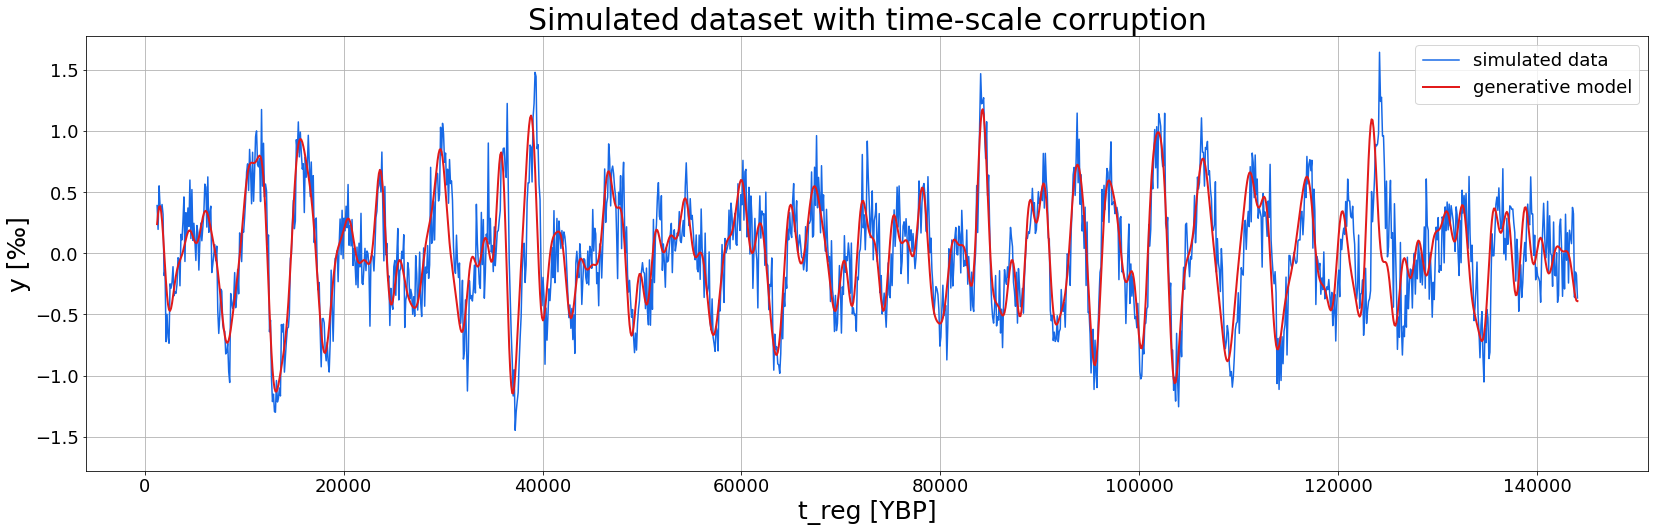

In [149]:
# plot simulation 
plot_simulation(df_sim, 0, n)

# Bayesian inference

### Bayes theorem

$$
f(t,\theta|y_{corr\_obs}) \propto f(y_{corr\_obs}|t,\theta)f(t,\theta)
$$

where $\theta = (a,b,c,\sigma, A_1, ..., A_{N\_cycle\_inf}, \phi_1, ..., \phi_{N\_cycle\_inf})$.

Note that in this section we use the parameters $(a,b,c,\sigma)$ instead of $(\mu, \tau, \sigma,\sigma_y)$ because the equations are easier to read.

### Likelihood
We assumed that the white noise on the sinusoidal signal is Gaussian distributed, thus:

$$
f(y_{corr\_obs}|t,\theta) \propto \exp\Bigg(-\frac{1}{2\sigma_y^2}\sum_{i=1}^n\Big(y_{corr\_obs,i} - \sum_{l=1}^{N_{cycle\_inf}}\big(A_l\cos(\omega_l t_{i}+\phi_l)\big)\Big)^2\Bigg)
$$

namely

$$
y_{corr\_obs,i} \sim \mathcal{N}\Big(\sum_{l=1}^{N_{cycle\_inf}}\big(A_l\cos(\omega_l t_{i}+\phi_l)\big), \sigma_y\Big)
\ \ \ \ \ \ \ \ \ \ \ \ \ (\textbf{*})
$$

Where $N_{cycle\_inf}$ is the number of cycles exploited in the inference, in this case $N_{cycle\_inf}=N_{cycle}=29$. 

In the simpler case where $N_{cycle\_inf}=1$, $\phi_1=0$ and $A_1=1$ it is possible to express the above equation using a quadratic form (plus a linear and a costant term). After some calculations we get:

$$
f(y_{corr\_obs}|t,\theta) \propto \exp(-\frac{1}{2}y_{corr\_obs}^T \mathbb{A}_L y_{corr\_obs} + b_L^T y_{corr\_obs} + k_L)
$$

where

$$
\mathbb{A}_L = \frac{1}{\sigma^2} I
$$

$$
b_{L,i} = -\frac{1}{2\sigma^2} \tilde{b}_{L,i} \hspace{2mm} \text{with} \hspace{2mm} \tilde{b}_{L,i} = -2\cos(\omega t_{i}) \vee i
$$

$$
k_{L} =  -\frac{1}{2\sigma^2} \sum_{i=1}^n \tilde{k}_{L,i} \hspace{2mm} \text{with} \hspace{2mm} \tilde{k}_{L,i} = \cos^2 (\omega t_{i}) \vee i
$$

Note that there is a relationship between the canonical form of the density of a multivariate Gaussian distribution and the one we just derived. In particular for the exponent terms we have:

$$
-\frac{1}{2}(x - \mu)^T \Sigma^{-1} (x - \mu) = -\frac{1}{2}x^T  \Sigma^{-1} x + (\Sigma^{-1} \mu)^T x + (\Sigma^{-1} \mu)^T \mu
$$

where $\Sigma$ is the symmetric covariance matrix (the inverse is usually referred to as precision matrix). Hence, comparing the right-hand side with what we obtained before, we find that:

$$
\mathbb{A}_L = \Sigma_L^{-1}
$$

from which we can derive the covariance matrix by inverting $\mathbb{A}_L$, namely  $\Sigma_L = \mathbb{A}_L^{-1}$ (in this case it is very straightforward, in fact $\Sigma = \sigma^2 I$) and:

$$
b_L = \Sigma_L^{-1} \mu_L
$$

from which we can derive the mean vector $\mu$ multiplying both sides by the covariance matrix, namely $\mu_L = \Sigma_L b_L$ (this is also very simple, in fact we obtain $\mu_{L,i} = \cos(\omega t_i) \vee i$).

Finally:

$$
f(y_{corr\_obs}|t, \theta) \propto \exp(-\frac{1}{2} (y_{corr\_obs} - \mu_L)^T \Sigma_L^{-1} (y_{corr\_obs} - \mu_L))
$$

This was a very simple case (in fact we had already obtained the same result at the beginning just by looking at the original form with the summation term), but the same machinery will be useful in a moment.

### Prior
By applying the definition of conditional probability we get:

$$
f(t,\theta) = f(t|\theta)f(\theta)
$$

Let's focus on the first term, $f(t|\theta)$. Recall that the corrupted time-scale is build by adding to the previous time step a stochastic variable:

$$
t_{i} = t_{i-1} + \xi_{i}
$$

Therefore we can perform the following change of variables:

$$
t_{i} \rightarrow \xi_{i} = t_{i} - t_{i-1}
$$

Using vector notation we have:

$$
\xi(t) = (t_1 - t_0, \dots, t_i - t_{i-1},   \dots, t_N - t_{N-1})
$$

Finally we can write the following one:

$$
f(t|\theta) = f(\xi|\theta)\det(J_{\xi})
$$

where $\det(J_{\xi})$ is the determinant of the Jacobian of the vector-valued function $\xi(t)$. In this case, since we have a linear transformation, it holds $\det(J_{\xi}) = 1$.

Let's focus on the first term, $f(\xi|\theta)$. We assumed that the time-scale corruption is explained by an autoregressive model AR(1):

$$
\xi_{i} = a + b \cdot \xi_{i-1} + c \cdot \epsilon_{i}
$$

So, similarly to what we did with $y$, we have:

$$
f(\xi|\theta) \propto \exp(-\frac{1}{2c^2}\sum_{i=1}^n(\xi_{i} - (a + b \cdot \xi_{i-1}))^2)
\ \ \ \ \ \ \ \ \ \ \ \ \ (\textbf{**})
$$

We would like to express the above equation using a quadratic form. For simplicity we set $a = 0$ (which implies $\xi_0 = a/(1-b) = 0$) and after some calculations we get:

$$
f(\xi|\theta) \propto \exp(-\frac{1}{2}\xi^T A_P\xi)
$$

where

$$
\mathbb{A}_P = \frac{1}{c^2} \tilde{\mathbb{A}}_P \hspace{2mm} \text{with} \hspace{2mm} \tilde{\mathbb{A}}_P = 
\begin{pmatrix} (1+b^2) & -b & & & \\ -b & (1+b^2) & -b & & \\ & -b & \ddots & \ddots & \\ & & \ddots & \ddots & -b \\ & & & -b & 1 \end{pmatrix}
$$

By setting $a \neq 0$ and after some calculation we obtain an additional linear and constant term be added to the quadratic form obtained previously:

$$
f(\xi|\theta) \propto \exp(-\frac{1}{2}\xi^T \mathbb{A}_P\xi + b_{P}^T \xi + k_P)
$$

where

$$
\mathbb{A}_P = \frac{1}{c^2} \tilde{\mathbb{A}}_P \hspace{2mm} \text{with} \hspace{2mm} \tilde{\mathbb{A}}_P =
\begin{pmatrix} (1+b^2) & -b & & & \\ -b & (1+b^2) & -b & & \\ & -b & \ddots & \ddots & \\ & & \ddots & \ddots & -b \\ & & & -b & 1 \end{pmatrix}
$$

$$
b_{P} = -\frac{1}{2c^2}\tilde{b}_{P} \hspace{2mm} \text{with} \hspace{2mm} \tilde{b}_P =
\begin{pmatrix} 2a(b-1) -2b\xi_0\\ 2a(b-1) \\ 2a(b-1) \\ \vdots \\ 2a \end{pmatrix}
$$

$$
k_P = -\frac{1}{2c^2}\tilde{k}_P \hspace{2mm} \text{with} \hspace{2mm}
\tilde{k}_P = a^2N + b^2\xi_0^2 +2ab\xi_0
$$

We can use the same machinery described earlier to obtain the canonical form of this multivariate Gaussian distribution:

$$
\mathbb{A}_P = \Sigma_P^{-1} \hspace{2mm} \text{thus} \hspace{2mm} \Sigma_P = \mathbb{A}_P^{-1}
$$


which is not easy to be inverted, and:

$$
b_P = \Sigma_P^{-1} \mu_P \hspace{2mm} \text{thus} \hspace{2mm} \mu_P = \Sigma_P b_P
$$

which could have been inferred by considering the expected value of $\xi$, therefore $\mu_{P,i} = a/(1-b) \hspace{2mm} \forall \hspace{2mm} i$. Finally:

$$
f(\xi|\theta) \propto \exp(-\frac{1}{2} (\xi - \mu_P)^T \Sigma_P^{-1} (\xi - \mu_P)) .
$$

Regarding the priors of the other parameters, we have:

$$
\mu  \sim \mathcal{N} (100, 1)
$$

$$
\sigma \sim \text{Gamma}(1, 1)
$$

$$
\tau \sim \text{Gamma}(25, 0.025)
$$

$$
\sigma_y \sim \text{Gamma}(2, 10)
$$

Priors on $\sigma$ and $\tau$ are not centered in the true values so as to simulate the real case in which we do not have such detailed information about these parameters.


### Posterior

Putting all the parts together results in:

$$
f(t,\theta|y_{corr\_obs}) \propto \exp(-\frac{1}{2} (y_{corr\_obs} - \mu_L)^T \Sigma_L^{-1} (y_{corr\_obs} - \mu_L)) \cdot \exp(-\frac{1}{2} (\xi - \mu_P)^T \Sigma_P^{-1} (\xi - \mu_P)) \cdot f(\theta)
$$

However from the point of view of the computational implementation and for the case where $N_{cycle\_inf}\neq1$ it is more convenient to represent the posterior as follows:

$$
f(t,\theta|y_{corr\_obs}) \propto \exp\Bigg(-\frac{1}{2\sigma_y^2}\sum_{i=1}^n\Big(y_{corr\_obs,i} - \sum_{l=1}^{N_{cycle\_inf}}\big(A_l\cos(\omega_l t_{i}+\phi_l)\big)\Big)^2\Bigg) \cdot \exp\Big(-\frac{1}{2c^2}\sum_{i=1}^n(\xi_{i} - (a + b \cdot \xi_{i-1}))^2\Big) \cdot f(\theta)
$$

# MCMC sampling
Monte Carlo Markov Chain (MCMC) are very powerful, generic methods, for approximately generating samples from any arbitrary distribution. It uses the idea of generating a Markov chain whose limiting distribution is equal to desired target distribution.

### STAN
Stan is a probabilistic programming language for statistical modeling and high-performance statistical computation. In particular we used it to perform Bayesian inference with MCMC sampling. Two MCMC algorithms are used in Stan, the Hamiltonian Monte Carlo (HMC) algorithm and its adaptive variant the no-U-turn sampler (NUTS).

### HMC
The Hamiltonian Monte Carlo algorithm starts at a specified initial set of parameters $\theta$; in Stan, this value is either user-specified or generated randomly. Then, for a given number of iterations, a new momentum vector is sampled and the current value of $\theta$ is updated using the leapfrog integration method. Then a Metropolis acceptance step is applied, and a decision is made whether to update $\theta$ to the new state or keep the existing one.

### STAN implementation
The code for the STAN model is presented here, divided in different parts:
- **data**: declaration of the parameters passed to the algorithm 
    - dataset length $n$
    - simulated values $y_{corr\_obs}$
    - number of inferred cycles $N_{cycle\_inf}$ with respective frequencies $f$
    - time step $\Delta t$
- **parameters** and **transformed parameters**: declaration of the parameters the algorithm is going to infer
    - inferred times $t$
    - $\mu$, $\sigma$ and $\tau$ of $\xi$
    - constant factor multiplying the white noise $\sigma_y$
    - amplitude $A$ and phase $\phi$ of all the $N_{cycle\_inf}$ selected cycles
    - vector $\xi$ used to corrupt the time-scale (defined using $t$)
- **model**: priors on the parameters and implementation of the posterior
    - normal prior on $\mu$ and gamma priors on $\sigma$, $\tau$ and $\sigma_y$
    - likelihood implementation as explained above in the equation ($\textbf{*}$)
    - prior implementation as explained above in the equation ($\textbf{**}$)

The length of both $\xi$ and $t$ inferred vectors is $n-1$, due to the fact that the first values are fixed respectively to $t_0=1250$ and $\xi_0=\mu$.

In [14]:
# define the program code for stan
code = """
data {

    int<lower=0> n;
    vector[n] y_obs;
    
    int<lower=0> N_cycle_inf;
    vector<lower=0>[N_cycle_inf] freq;

    real<lower=0> dt;

}

parameters {

    ordered[n-1] t;

    real mean;
    real<lower=0> sd;
    real<lower=50> tau;

    real<lower=0> sigma_y;

    vector<lower=0>[N_cycle_inf] A;
    vector<lower=0, upper=2*pi()>[N_cycle_inf] ph;
    
}

transformed parameters {

    //declare xi
    vector[n-1] xi;
        
    //define xi
    xi[1] = t[1]-1250;  
    for(i in 2:n-1) {
        xi[i] = t[i]-t[i-1];  
    }

}

model {

    //priors
    mean ~ normal(100, 1);
    sd ~ gamma(1, 1);
    tau ~ gamma(25, 0.025);
    sigma_y ~ gamma(2, 10);

    vector[n] mean_y;

    mean_y[1] = 0;
    for(i in 1:N_cycle_inf) {
        mean_y[1] += A[i]*cos(2*pi()*freq[i]*1250+ph[i]);
    }
    y_obs[1] ~ normal(mean_y[1], sigma_y);

    for(i in 2:n) {
        mean_y[i] = 0;
        for(j in 1:N_cycle_inf) {
            mean_y[i] += A[j]*cos(2*pi()*freq[j]*t[i-1]+ph[j]);
        }
        y_obs[i] ~ normal(mean_y[i], sigma_y);
    }
 
    xi[1] ~ normal(mean, sd*sqrt(2*(dt/tau)));
    
    for (i in 2:n-1) {
      xi[i] ~ normal(mean*(dt/tau)+(1-(dt/tau))*xi[i-1], sd*sqrt(2*(dt/tau)));
    }

}
"""

Assignment of the known data values to the data dictionary and building of the STAN model.

In [15]:
# number of cycles to be inferred
N_cycle_inf = 29

# assign the data to the dictionary
data = {'n':df_sim.shape[0], 'y_obs':df_sim['y_corr_obs'].values,
        'N_cycle_inf':N_cycle_inf, 'freq':freq[:N_cycle_inf], 'dt':dt}

# build the model
#posterior = stan.build(code, data=data, random_seed=12345)

In order to sample from the posterior we have to choose the number of chains, with the corresponding length of the warmups and the number of samples.

In [16]:
# sample from the model
n_chains = 4
n_warmup = 2000
n_sample = 4000

'''fit = posterior.sample(num_chains=n_chains, num_samples=n_sample, num_warmup=n_warmup,
                    init=[{'A':df_cycle['A'].values[:N_cycle_inf],
                        'ph':df_cycle['ph'].values[:N_cycle_inf],
                        't':df_sim['t_reg'].values,
                        'mean':100, 'sd':1, 'tau':1000, 'sigma_y':0.2}]*n_chains)'''

"fit = posterior.sample(num_chains=n_chains, num_samples=n_sample, num_warmup=n_warmup,\n                    init=[{'A':df_cycle['A'].values[:N_cycle_inf],\n                        'ph':df_cycle['ph'].values[:N_cycle_inf],\n                        't':df_sim['t_reg'].values,\n                        'mean':100, 'sd':1, 'tau':1000, 'sigma_y':0.2}]*n_chains)"

# Results

The results of the Stan inference are converted into the <code>df\_inf</code> dataframe.

In [17]:
#df_inf = fit.to_frame()
#name = 'run_taufixed_sd5.csv'
#df_inf.to_csv(name, index=True)

In [18]:
# load dataframe
path_name = 'run_synthetic.csv'
df_inf = pd.read_csv(path_name)

The dataframe is flattened by considering only the median value for each sample of the Markov chains and it is also possible to reduce it with <code>thinning</code> parameter.

In [19]:
# flattening
flattening = n_chains
df_inf = df_inf.groupby(np.arange(len(df_inf))//flattening).median()

# thinnng
thinning = 1
df_inf = df_inf.iloc[np.arange(0, n_sample*(n_chains - flattening + 1), thinning)]

The median of the samples is chosen as the inferred value for each parameter in $\theta = (\mu, \tau, \sigma,\sigma_y, A_1, ..., A_{N\_cycle\_inf}, \phi_1, ..., \phi_{N\_cycle\_inf})$ and $t=(t_1,t_2,...,t_n)$ defining respectively $\theta_{inf}$ and $t_{inf}$.

In [20]:
# compute the estimator of each parameter as the median of the samples
def infer_parameter(keys, df):

    param_inf = {}

    for key in keys:
        if key == 't.0':
            param_inf[key] = t_corr[0]
        else:
            # inferred parameters
            param_inf[key] = np.median(df[key])
    
    return param_inf

In [21]:
# auto-regressive inferred parameters
param_AR_inf = infer_parameter(list(param_AR.keys()), df_inf)

# sigma_y inferred parameter
param_sigma_y_inf = infer_parameter(list(param_sigma_y.keys()), df_inf)

# A inferred parameters
param_A_inf = infer_parameter(list(param_A.keys())[:N_cycle_inf], df_inf)

# ph inferred parameters
param_ph_inf = infer_parameter(list(param_ph.keys())[:N_cycle_inf], df_inf)

# t inferred parameters
param_t_inf = infer_parameter(list(param_t.keys()), df_inf)

# concatenate dictionaries
param_inf = {**param_AR_inf, **param_sigma_y_inf, **param_A_inf, **param_ph_inf}
    
#for key in list(param_inf.keys()):
#    print(key+':', round(param_inf[key], 4))

The true and inferred values of the parameters in $\theta$ are here printed.

In [22]:
# print true and inferred parameters
for key in list(param_inf.keys()):

    print(key)

    prec = None
    if key in ['mean', 'sd']:
        prec = 1
    elif key in ['tau']:
        prec = 0
    elif key in ['sigma_y']:
        prec = 3
    elif key in ['A.'+str(i+1) for i in range(0, N_cycle_inf)]:
        prec = 3
    elif key in ['ph.'+str(i+1) for i in range(0, N_cycle_inf)]:
        prec = 2

    print('true:', round(param[key], prec),
          'inf:', round(param_inf[key], prec),
          '+-', round(np.sqrt(np.var(df_inf[key])), prec))

mean
true: 100 inf: 99.8 +- 0.3
sd
true: 5 inf: 4.9 +- 0.4
tau
true: 1500 inf: 1027.0 +- 104.0
sigma_y
true: 0.2 inf: 0.197 +- 0.002
A.1
true: 0.176 inf: 0.185 +- 0.005
A.2
true: 0.177 inf: 0.177 +- 0.005
A.3
true: 0.145 inf: 0.146 +- 0.005
A.4
true: 0.144 inf: 0.152 +- 0.005
A.5
true: 0.157 inf: 0.157 +- 0.005
A.6
true: 0.135 inf: 0.14 +- 0.005
A.7
true: 0.119 inf: 0.114 +- 0.005
A.8
true: 0.115 inf: 0.127 +- 0.005
A.9
true: 0.117 inf: 0.124 +- 0.005
A.10
true: 0.127 inf: 0.122 +- 0.005
A.11
true: 0.122 inf: 0.121 +- 0.005
A.12
true: 0.093 inf: 0.095 +- 0.005
A.13
true: 0.102 inf: 0.116 +- 0.006
A.14
true: 0.1 inf: 0.085 +- 0.006
A.15
true: 0.106 inf: 0.123 +- 0.005
A.16
true: 0.099 inf: 0.107 +- 0.005
A.17
true: 0.065 inf: 0.079 +- 0.005
A.18
true: 0.084 inf: 0.094 +- 0.005
A.19
true: 0.095 inf: 0.105 +- 0.005
A.20
true: 0.072 inf: 0.076 +- 0.004
A.21
true: 0.071 inf: 0.076 +- 0.004
A.22
true: 0.079 inf: 0.089 +- 0.004
A.23
true: 0.119 inf: 0.119 +- 0.005
A.24
true: 0.063 inf: 0.052 

The following graph shows the Markov chain traces and autocorrelation plots of the parameters $\mu$, $\sigma$, $\tau$ and $\sigma_y$.

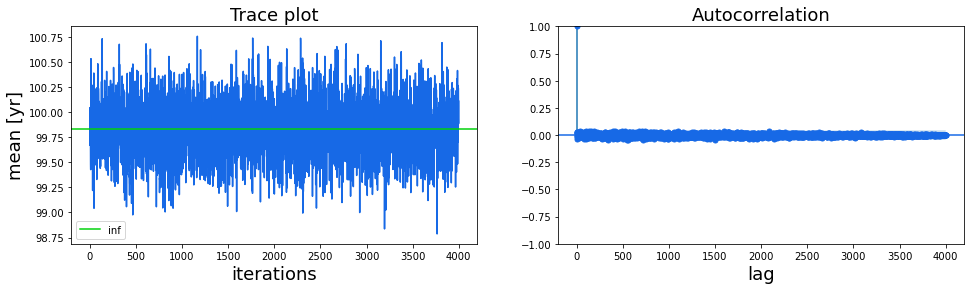

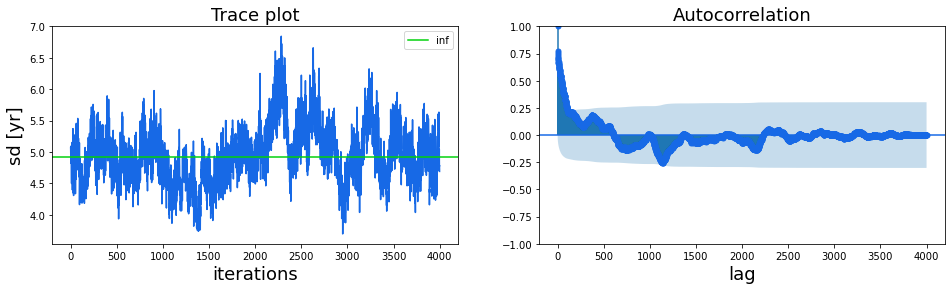

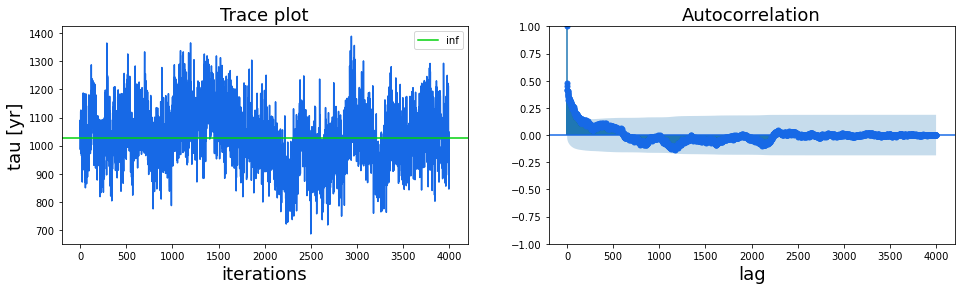

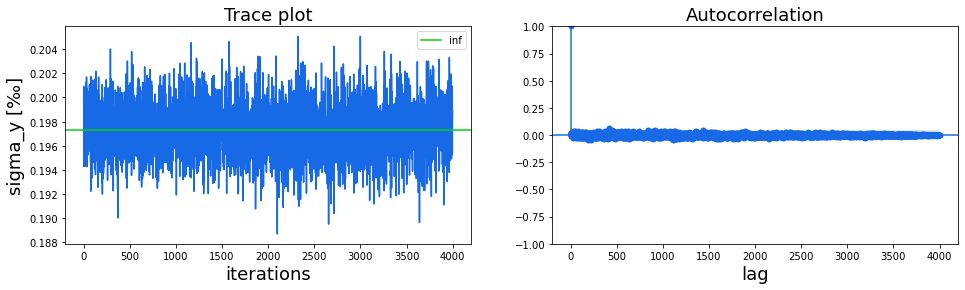

In [82]:
def plot_mc_acf(df, key):

    # plot
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,4))

    # markov chain
    ax[0].plot(np.arange(0, df.shape[0]), df[key].values, color=col_blue)
    ax[0].axhline(y=np.median(df[key]), color=col_green, label='inf')
    ax[0].set_xlabel('iterations')
    ax[0].tick_params(axis='x',labelsize=10)
    ax[0].tick_params(axis='y',labelsize=10)
    if key == 'sigma_y':
        ax[0].set_ylabel(key + ' [‰]')
    else :
        ax[0].set_ylabel(key + ' [yr]')
    ax[0].set_title('Trace plot')
    ax[0].legend()
 
    # autocorrelation
    plot_acf(df[key], ax=ax[1], lags = int(np.floor(n_sample))-1, color=col_blue)
    ax[1].set_xlabel('lag')
    ax[1].tick_params(axis='x',labelsize=10)
    ax[1].tick_params(axis='y',labelsize=10)

    plt.show()


for key in list({**param_AR_inf, **param_sigma_y_inf}.keys()):
    plot_mc_acf(df_inf, key)

The diagonal of the next graph shows the marginalized posterior histograms of the parameters $\theta$. Below it there are the pairwise scatter plots, while above it there are the correlation coefficients.

In [78]:
# plot pairwise scatter plot matrix, histograms and correlation coefficients
def scatterplot_matrix(param, param_inf, n, df):

    # auto-regressive and sigma_y
    key = list(param_inf.keys())[:4]
    # A
    key = key + ['A.'+str(i+1) for i in range(0, n)]
    # ph
    key = key + ['ph.'+str(i+1) for i in range(0, n)]

    # plot
    fig, ax = plt.subplots(nrows=len(key), ncols=len(key), figsize=(len(key)*2, len(key)*2))

    # rows
    for i in range(0,len(key)):

        # columns
        for j in range(0,len(key)):

            # histograms
            if j == i:
                ax[i,i].hist(df[key[i]], bins=25, color=col_blue)
                ax[i,i].axvline(x=param[key[i]], color=col_red, linestyle='--', label='true '+key[i])
                ax[i,i].axvline(x=param_inf[key[i]], color=col_green, linestyle='--', label='inf '+key[i])
                ax[i,i].set_title(key[i])
                #ax[i,i].legend()
                ax[i,i].grid()

            # scatter plots
            elif j < i:
                ax[i,j].scatter(df[key[j]], df[key[i]], color=col_blue, alpha=0.5)
                ax[i,j].axvline(x=param[key[j]], color=col_red, linestyle='--', label='true '+key[j])
                ax[i,j].axhline(y=param[key[i]], color=col_red, linestyle='--', label='true '+key[i])
                #ax[i,j].legend()
                ax[i,j].grid()

            # correlation coefficients
            else:
                rho = np.corrcoef(df[key[i]], df[key[j]])[0,1]
                ax[i,j].text(0.5, 0.5, str(np.round(rho, 2)), ha = 'center', va = 'center')
                ax[i,j].xaxis.set_ticklabels([])
                ax[i,j].yaxis.set_ticklabels([])

    # set the spacing between subplots
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)
                
    plt.show()

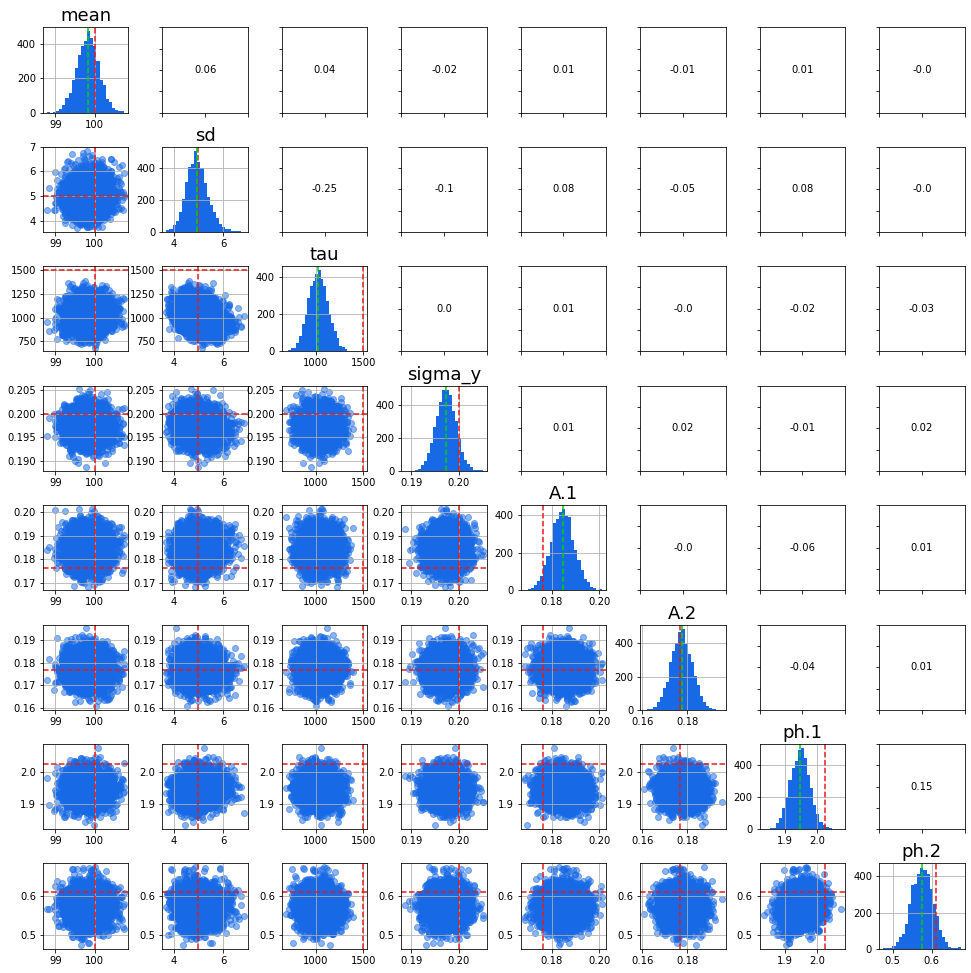

In [79]:
# pairwise scatter plot matrix, histograms (marginals) and correlation coefficients
scatterplot_matrix(param, param_inf, 2, df_inf)

Here are plotted the inferred values of the $\xi_{inf,i}$ (again the median of the samples) of the auto-regressive process with the relative 95% credible interval upon the simulated ones.

In [121]:
# plot inferred autoregressive model
def infer_AR(xi, df):
        
    # xi inferred parameters and 95% credible interval
    xi_inf = {}
    xi_inf_95CI = {}
    for key in ['xi.'+str(i) for i in range(0, n)]:
        if key == 'xi.0':
            xi_inf[key] = xi[0]
            xi_inf_95CI[key] = [xi[0], xi[0]]
        else:
            xi_inf[key] = np.median(df[key])
            xi_inf_95CI[key] = np.quantile((df[key]), [0.025, 0.975])
            
    low = [x[0] for x in list(xi_inf_95CI.values())]
    high = [x[1] for x in list(xi_inf_95CI.values())]

    fig, ax = plt.subplots(figsize=(24,8))
    ax.vlines(x=1250 + np.arange(0, n*100, 100), ymin=low, ymax=high, color=col_grey, alpha=0.3, label='95% CI')
    ax.plot(1250 + np.arange(0, n*100, 100), xi, color=col_blue, label='simulation')
    ax.plot(1250 + np.arange(0, n*100, 100), list(xi_inf.values()), color=col_green, label='inference', lw=2.5)
    ax.axhline(y=mean, color='k', linestyle='--')
    ax.set_xlabel('t_reg [YBP]', fontsize=23)
    ax.set_ylabel(r'$\xi$ [yr]', fontsize=23)
    ax.set_title('Inferred auto-regressive process', fontsize=27)
    ax.tick_params(axis='x',labelsize=18)
    ax.tick_params(axis='y',labelsize=18)
    ax.grid()
    ax.legend(fontsize=16)
    plt.show()

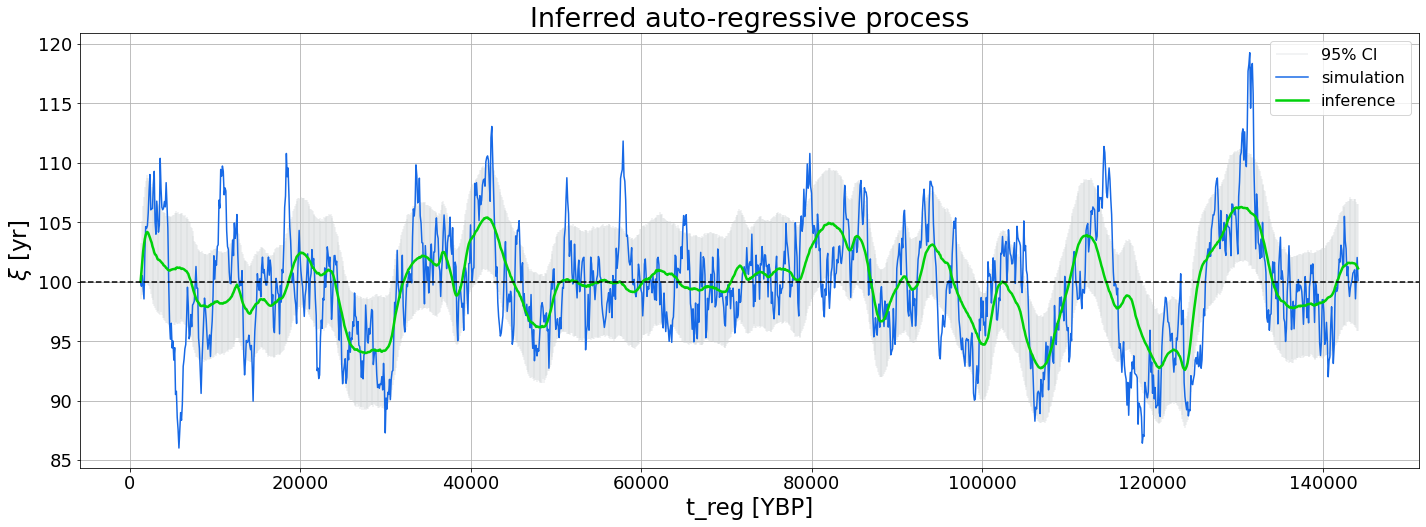

In [122]:
# plot inferred autoregressive model
infer_AR(xi, df_inf)

Regarding the parameters $t=(t_1,t_2,...,t_n)$ here are shown the trace of the Markov chain and the marginalized posterior histogram of some of them. The respective inferred $t_{inf,i}$, regular $t_{reg,i}$ and corrupted $t_{corr,i}$ values are also plotted.

In [146]:
# plot trace (Markov chain) and histogram (marginal) of a t inferred parameter
def traceplot(param_t, param_t_inf, i, df):

    key = 't.'+str(i)

    # plot
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

    ax[0].plot(np.arange(0, df.shape[0]), df[key], color=col_blue)
    ax[0].axhline(y = param_t[key], color=col_red, linestyle='--', label='true '+key)
    ax[0].axhline(y = param_t_inf[key], color=col_green, linestyle='--', label='inf '+key)
    ax[0].axhline(y = t_reg[i], color='k', linestyle='--', label='reg '+key)
    ax[0].set_xlabel('iterations')
    ax[0].set_ylabel(key + ' [yr]')
    ax[0].set_title('Trace plot')
    ax[0].tick_params(axis='x',labelsize=10)
    ax[0].tick_params(axis='y',labelsize=10)
    ax[0].legend()
    ax[0].grid()

    ax[1].hist(df[key], bins=25, color=col_blue)
    ax[1].axvline(x = param_t[key], color=col_red, linestyle='--', label='true '+key)
    ax[1].axvline(x = param_t_inf[key], color=col_green, linestyle='--',lw = 3, label='inf '+key)
    ax[1].axvline(x = t_reg[i], color='k', linestyle='--', label='reg '+key)
    ax[1].set_xlabel(key + ' [yr]')
    ax[1].set_title('Marginalized posterior histogram')
    ax[1].tick_params(axis='x',labelsize=10)
    ax[1].tick_params(axis='y',labelsize=10)
    ax[1].legend()
    ax[1].grid()

    #fig.suptitle('Marginal Posterior of '+key)

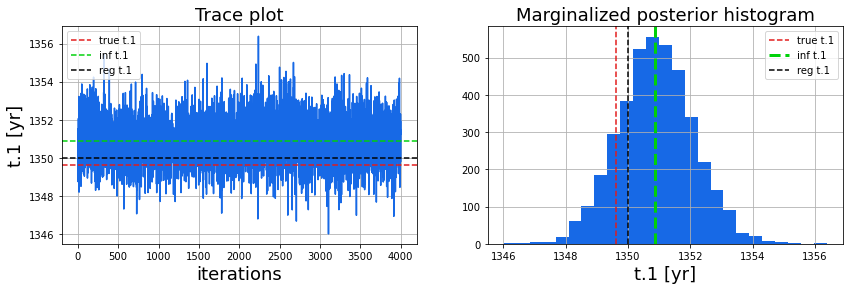

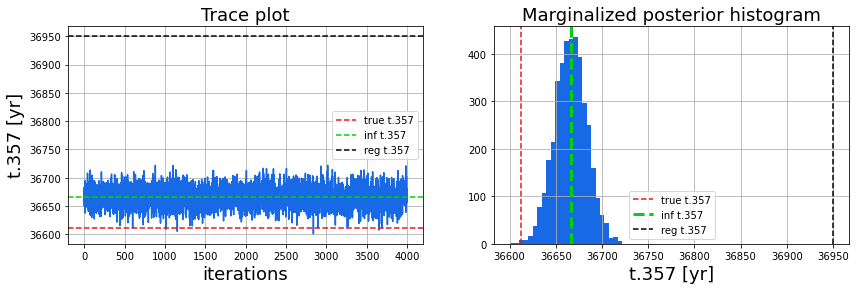

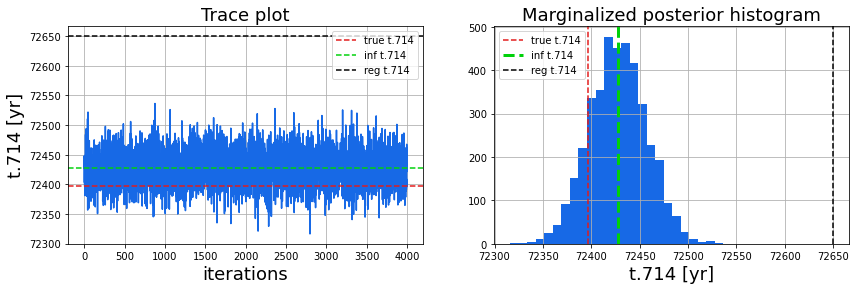

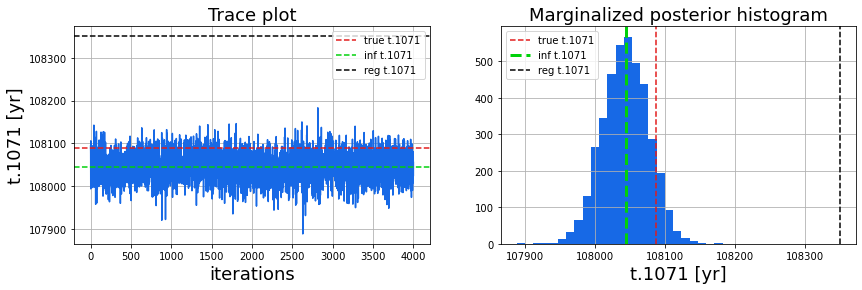

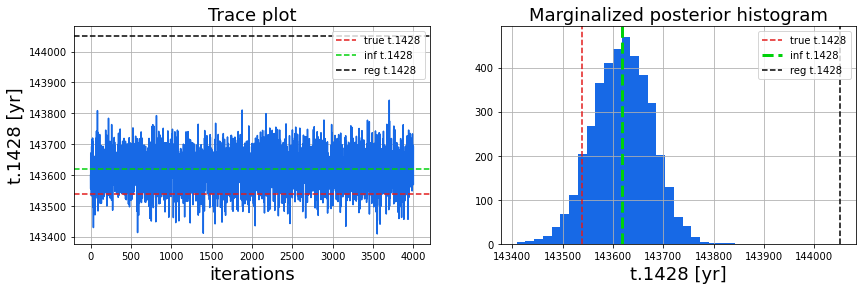

In [147]:
# plot trace (Markov chain) and histogram (marginal) of a t inferred parameter
ts = [1, 0.25*n, 0.5*n, 0.75*n, n-1]
for i in ts:
    traceplot(param_t, param_t_inf, int(i), df_inf)

In [30]:
# 95% credible interval of t inferred parameters
param_t_inf_95CI = param_t_inf.copy()
for key in list(param_t_inf.keys()):
    if key == 't.0':
        param_t_inf_95CI[key] = [t_reg[0], t_reg[0]]
    else:
        param_t_inf_95CI[key] = np.quantile((df_inf[key]), [0.025, 0.975])

This graph shows in blue the differences between $t_{corr,i}$ and $t_{reg,i}$ while in green those between $t_{inf,i}$ and $t_{reg,i}$ with the corresponding 95% credibile interval of the inferred time parameters.

In [129]:
# plot credible interval of all t inferred parameters
def credible_interval(t_reg, param_t, param_t_inf, param_t_inf_95CI):

    # shifted true value
    y_true = list(param_t.values()) - t_reg
    # shifted inferred value
    y_inf = list(param_t_inf.values()) - t_reg
    # 95% credible interval
    low = [x[0] for x in list(param_t_inf_95CI.values())] - t_reg
    high = [x[1] for x in list(param_t_inf_95CI.values())] - t_reg

    # plot
    fig, ax = plt.subplots(figsize=(24, 8))
    ax.vlines(x=np.arange(0, len(y_true)), ymin=low, ymax=high, color=col_grey, alpha=0.3, label='95% CI')
    ax.plot(np.arange(0, len(y_true)), y_true, color=col_blue, label='simulation')
    ax.plot(np.arange(0, len(y_inf)), y_inf, color=col_green, label='inference', lw=1.5)
    ax.axhline(y = 0, color='k', linestyle='--')
    ax.set_xlabel('index', fontsize=23)
    ax.set_ylabel(r'$\Delta$t [yr]', fontsize=23)
    ax.tick_params(axis='x',labelsize=18)
    ax.tick_params(axis='y',labelsize=18)
    ax.legend(fontsize=16)
    ax.grid()
    ax.set_title('Difference between the corrupted and regular time-scale', fontsize=27)
    plt.show()

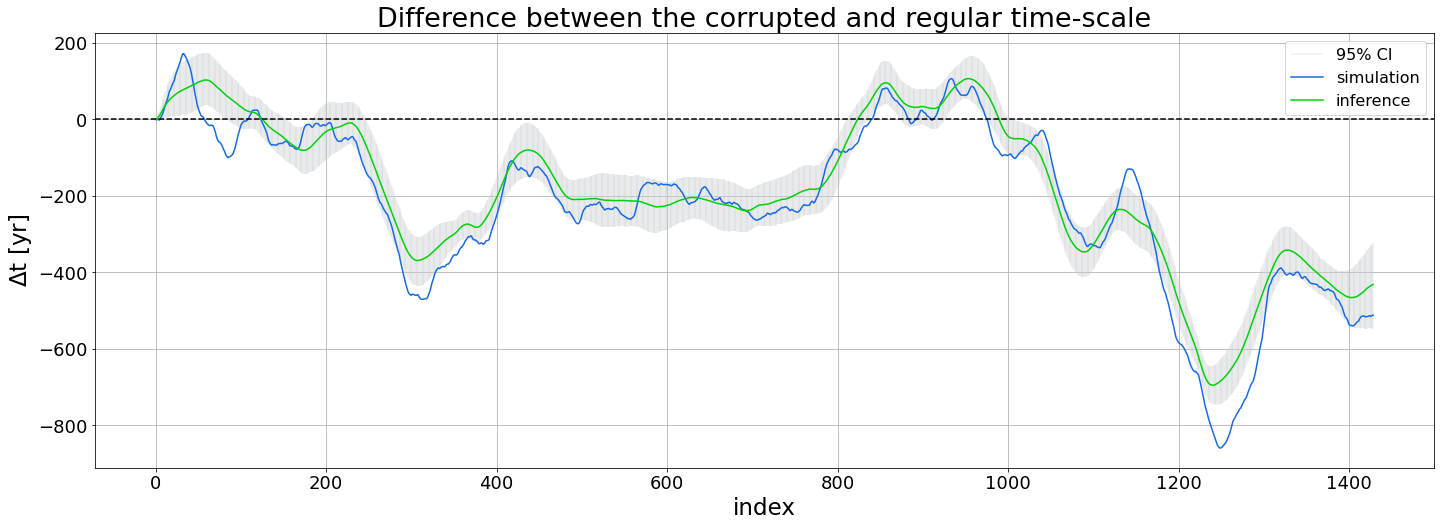

In [130]:
credible_interval(df_sim['t_reg'], param_t, param_t_inf, param_t_inf_95CI)

At this point with the inferred values $\theta_{inf}$ and $t_{inf}$ it is possible to calculate the fit of the $y_{corr\_obs,i}$ as:

$$
y_{fit, i} = \sum_{l=1}^{N_{cycle\_inf}}(A_{inf,l}\cos(\omega_l t_{inf,i}+\phi_{inf,l})).
$$




In [33]:
# compute fit
def fit_data(param_A_inf, param_ph_inf, param_t_inf, freq, N_cycle_inf, n):

    A = list(param_A_inf.values())
    ph = list(param_ph_inf.values())
    t = np.array(list(param_t_inf.values()))

    fit = np.zeros(n)
    for i in range(0, N_cycle_inf):
        fit += A[i]*np.cos(2*np.pi*freq[i]*t + ph[i])

    return fit

In [34]:
# compute fit
y_fit = fit_data(param_A_inf, param_ph_inf, param_t_inf, freq, N_cycle_inf, n)

Here are plotted the signal $y_{corr\_obs,i}$ and $y_{fit,i}$ (respectively the simulated data and the fit) as a function of $t_{reg, i}$.

In [139]:
def plot_fit(df, fit, start, end):

    df = df[start:end]
    fit = fit[start:end]

    # plot
    fig, ax = plt.subplots(figsize=(28,8))

    ax.plot(df['t_reg'], df['y_corr_obs'], color=col_blue, label='observed data')
    ax.plot(df['t_reg'], fit, color = col_green, label='fit')
    ax.set_xlabel('t')
    ax.set_ylabel('y [‰]', fontsize=25)
    ax.set_xlabel('t_reg [YBP]', fontsize=25)
    ax.set_ylim((max(fit) + 3*sigma_y)*np.array([-1, 1]))
    ax.set_title('Simulated dataset with inferred fit', fontsize=30)
    ax.tick_params(axis='x',labelsize=18)
    ax.tick_params(axis='y',labelsize=18)
    ax.legend(fontsize=18)
    plt.grid()
    plt.show()

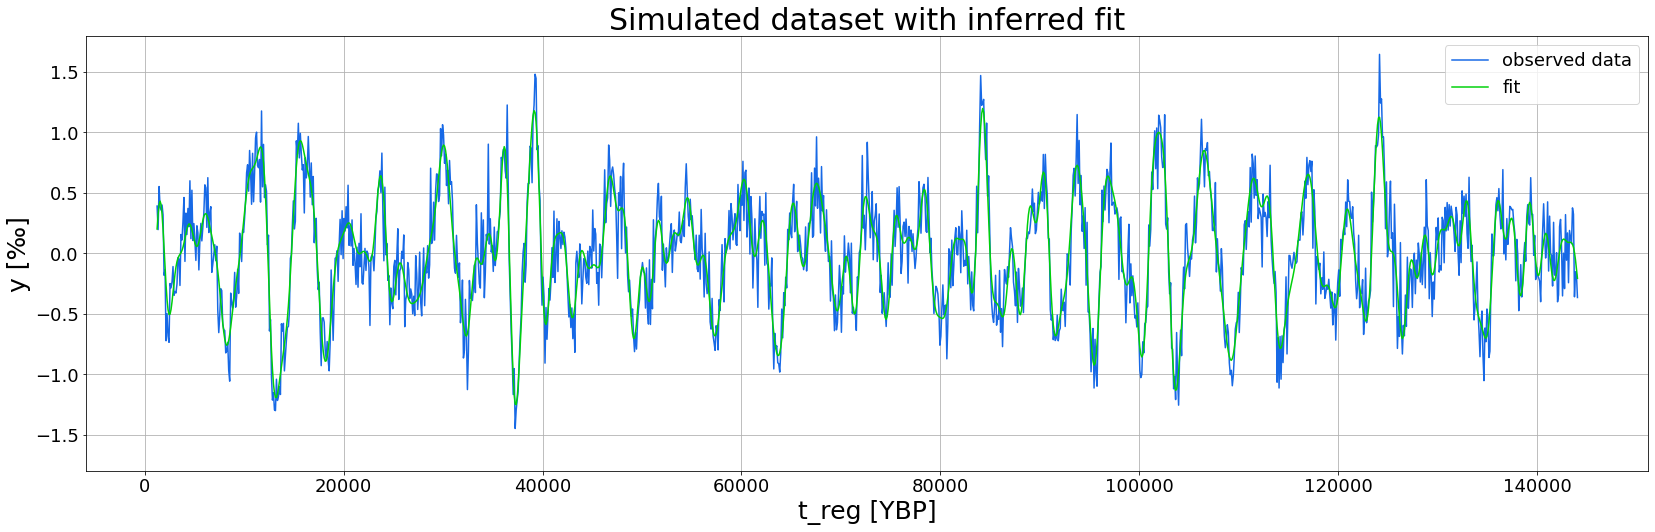

In [140]:
plot_fit(df_sim, y_fit, 0, n)

In this last graph the $y_{corr\_obs}$ is plotted both as a function of $t_{reg}$ (blue line) and $t_{inf}$ (green line). As expected the green line, representing the corrected dataset, follows the trend of the generative model $y_{reg}$. For better visualization only a portion of the dataset is shown.

In [142]:
def plot_inference(df, param_t_inf, start, end):

    df = df[start:end]
    t_inf = list(param_t_inf.values())[start:end]

    # plot
    fig, ax = plt.subplots(figsize=(24,8))

    ax.plot(df['t_reg'], df['y_corr_obs'], color=col_blue, label='observed data')
    ax.plot(df['t_reg'], df['y_reg'], color=col_red, label='generative model')
    ax.plot(t_inf, df['y_corr_obs'], color=col_green, label='corrected data')
    ax.set_xlabel('t [YBP]', fontsize=23)
    ax.set_ylabel('y [‰]', fontsize=23)
    ax.tick_params(axis='x',labelsize=18)
    ax.tick_params(axis='y',labelsize=18)
    ax.set_ylim(max(abs(df['y_corr_obs']))*np.array([-1.1, 1.1]))
    ax.set_title('Time-scale correction', fontsize=27)
    ax.legend(fontsize=16)
    plt.grid()
    plt.show() 

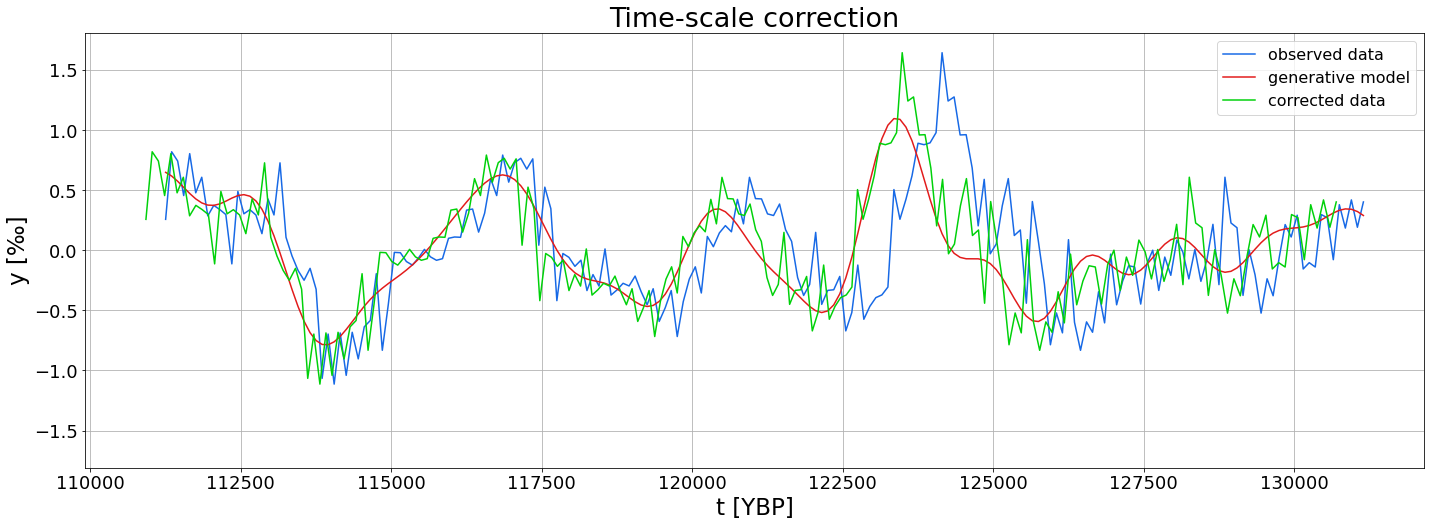

In [143]:
plot_inference(df_sim, param_t_inf, 1100, 1300)

Finally, to evaluate the results of inference, the following sums of squared residuals are reported:

$$
ssr_{sim} = \sum_{i=1}^{n}(t_{corr,i}-t_{reg,i})^2
$$

$$
ssr_{inf} = \sum_{i=1}^{n}(t_{inf,i}-t_{reg,i})^2
$$

and a comparison expressed as

$$
ssr_{reduction} = \frac {ssr_{sim} - ssr_{inf}}{ssr_{sim}}.
$$

In [39]:
# sum of squared residuals for the time scale correction
ssr = np.sum((df_sim['t_corr'] - df_sim['t_reg'])**2)
ssr_inf = np.sum((df_sim['t_corr'] - list(param_t_inf.values()))**2)
ssr_reduction = (ssr - ssr_inf)/ssr
print('simulation ssr:', ssr)
print('inference ssr:', ssr_inf)
print('ssr reduction', np.round(ssr_reduction, 4))

simulation ssr: 132165387.89979643
inference ssr: 5229377.144215419
ssr reduction 0.9604
